### Build A Basic Chatbot with LangGraph(Graph API) 

In [26]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages # add_msgs -> Reducers Appending msg in a list.

In [27]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [28]:
graph_builder

In [29]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [30]:
from langchain_groq import ChatGroq 
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama-3.1-8b-instant")

In [31]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000293036BBEF0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000293036BA570>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [32]:
llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000293036BB710>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000293036BA9C0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [33]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [34]:
graph_builder=StateGraph(State)

##Adding a node
graph_builder.add_node("llmchatbot",chatbot)

## Adding edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()

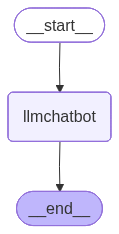

In [35]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [36]:
response=graph.invoke({"messages":"Hi"})

In [37]:
response["messages"]

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='6fb716af-1f11-4787-b82d-a4faf8fb0dfd'),
 AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.006290083, 'prompt_time': 0.001628408, 'queue_time': 0.050096992, 'total_time': 0.007918491}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--56ae1e1d-c391-46d3-b8a3-9b59dec047d0-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})]

In [38]:
for event in graph.stream({"messages":"Hi , who is the pm of india?"}):
    for value in event.values():
        print(value["messages"][-1].content)

The current Prime Minister of India is Narendra Modi. He has been serving as the Prime Minister since May 26, 2014.


### Chatbot with tools

In [39]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': '*   [Overview](https://www.ibm.com/think/topics/ai-agents#7281535) *   [Overview](https://www.ibm.com/think/topics/components-of-ai-agents#498277090) *   [Learning](https://www.ibm.com/think/topics/ai-agent-learning#498277087) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.com/think/tutorials/deploy-langgraph-react-agent-manage-it-support-tickets-watsonx-ai#1287801557) *   [Overview](https://www.ibm.com/think/topics/ai-agent-protocols#1509394340) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.com/think/tutorials/deploy-langgraph-react-agent-manage-it-support-tickets-watsonx-ai#80364620) *   [Overview](https://www.ibm.com/think/insights/ai-agent-governance#1268897081) *   [Overview](https://www.ibm.com/think/topics/ai-agent-use-cases#257779831) *   [Human resour

In [40]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [41]:
tools=[tool,multiply]

In [42]:
llm_with_tool=llm.bind_tools(tools)

In [43]:

llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000293036BB710>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000293036BA9C0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A

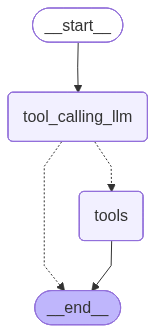

In [44]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [46]:
response['messages'][-1].content

'=function=tavily_search>{"query": "recent ai news", "topic": "news", "time_range": "month", "search_depth": "advanced"}</function>'

In [47]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================

=function=tavily_search>{"query": "recent ai news", "topic": "news", "time_range": "month", "search_depth": "advanced"}</function>


In [48]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (3f92yep47)
 Call ID: 3f92yep47
  Args:
    query: Recent AI news
    time_range: day
    topic: news
  multiply (gjsfea3yj)
 Call ID: gjsfea3yj
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "Recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/cisco-stock-csco-news-and-forecasts-on-dec-20-2025-ai-networking-tailwinds-security-zero-day-risk-and-fresh-wall-street-targets/", "title": "Cisco Stock (CSCO) News and Forecasts on Dec. 20, 2025: AI Networking Tailwinds, Security Zero‑Day Risk, and Fresh Wall Street Targets - ts2.tech", "score": 0.9425068, "published_date": "Sat, 20 Dec 2025 11:46:27 

### REACT AGEnT architecture

In [49]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

# from IPython.display import Image, display
# display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (x9kheaft7)
 Call ID: x9kheaft7
  Args:
    query: recent ai news
    time_range: day
    topic: news
  multiply (y58ah1bze)
 Call ID: y58ah1bze
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cnn.com/2025/12/21/economy/ai-hiring-complication", "title": "AI hiring is here. It’s making companies — and job seekers — miserable - CNN", "score": 0.6052631, "published_date": "Sun, 21 Dec 2025 08:00:01 GMT", "content": "As America’s labor market slows, AI-led interviews and auto-generated cover letters are dramatically changing the process of getting a job

### Adding memory in LangGraph

In [51]:

response=graph.invoke({"messages":"Hello my name is KRish"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is KRish
================================== Ai Message ==================================

Nice to meet you, KRish. How can I assist you today?


In [52]:
response=graph.invoke({"messages":"What is my name"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name
================================== Ai Message ==================================

I don't have any information about your name.


In [53]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 400.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [ ]:
config={"configurable":{"thread_id":1}}
response=graph.invoke({"messages":"Hi my name is Krish"},config=config)

response['messages'][-1].content

'Hello Krish, how can I assist you today?'

In [ ]:

response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)


Your name is Krish.


In [ ]:
response=graph.invoke({"messages":"Hey do you remember mmy name"},config=config)

print(response['messages'][-1].content)

Your name is Krish.


### Streaming

In [56]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [57]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

In [58]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
# from IPython.display import Image, display
# display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [ ]:

## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Krish And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='4627307a-f595-4aa3-a0e4-c12c552811c1'),
  AIMessage(content="Nice to meet you, Krish. Cricket is a fantastic sport, isn't it? Which team do you support, and do you have a favorite player? Are you more of a fan of Test cricket, One-Day Internationals (ODIs), or Twenty20 (T20) cricket? Let's chat about cricket!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 45, 'total_tokens': 111, 'completion_time': 0.082324085, 'prompt_time': 0.002194391, 'queue_time': 0.050522428, 'total_time': 0.084518476}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c92f0618-f501-439f-968d-0f89e9654cb4-0', usage_metadata={'input_tokens': 45, 'output_tokens': 66, 'total_tokens': 111})]}

### Streaming
Methods: .stream() and astream()

These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

values : This streams the full state of the graph after each node is called.
updates : This streams updates to the state of the graph after each node is called

In [59]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Krish, nice to meet you. Cricket is a fantastic sport, isn't it? Which team or player is your favorite? Are you a fan of the Indian cricket team, or do you support another team like Australia, England, or Pakistan?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 45, 'total_tokens': 96, 'completion_time': 0.076134071, 'prompt_time': 0.002184788, 'queue_time': 0.050171702, 'total_time': 0.078318859}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4ec00e9b-91c4-4b4c-8ff4-593ccfe3ddc3-0', usage_metadata={'input_tokens': 45, 'output_tokens': 51, 'total_tokens': 96})]}}


In [60]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='bdf5931c-d3f3-47f2-881c-f7016be5136f'), AIMessage(content="Hi Krish, nice to meet you. Cricket is a fantastic sport, isn't it? Which team or player is your favorite? Are you a fan of the Indian cricket team, or do you support another team like Australia, England, or Pakistan?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 45, 'total_tokens': 96, 'completion_time': 0.076134071, 'prompt_time': 0.002184788, 'queue_time': 0.050171702, 'total_time': 0.078318859}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4ec00e9b-91c4-4b4c-8ff4-593ccfe3ddc3-0', usage_metadata={'input_tokens': 45, 'output_tokens': 51, 'total_tokens': 96}), HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwarg

In [61]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Nice to meet you, Krish. Cricket is a fantastic sport, and I'm happy to chat with you about it. Are you a fan of a particular team or player? Do you enjoy playing cricket yourself or just watching and following it?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 45, 'total_tokens': 94, 'completion_time': 0.081917506, 'prompt_time': 0.002125183, 'queue_time': 0.049863056, 'total_time': 0.084042689}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--191e1aa1-a8ed-418b-8d24-b06a7829b9ec-0', usage_metadata={'input_tokens': 45, 'output_tokens': 49, 'total_tokens': 94})]}}


In [62]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='845331d0-e271-4496-85ec-efaf6c564d99'), AIMessage(content="Nice to meet you, Krish. Cricket is a fantastic sport, and I'm happy to chat with you about it. Are you a fan of a particular team or player? Do you enjoy playing cricket yourself or just watching and following it?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 45, 'total_tokens': 94, 'completion_time': 0.081917506, 'prompt_time': 0.002125183, 'queue_time': 0.049863056, 'total_time': 0.084042689}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--191e1aa1-a8ed-418b-8d24-b06a7829b9ec-0', usage_metadata={'input_tokens': 45, 'output_tokens': 49, 'total_tokens': 94}), HumanMessage(content='I also like football', additional_kwargs={}, response_metada

In [63]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'd5a01816-222a-4a9b-890e-865e96222447', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Krish and I like to play cricket', additional_kwargs={}, response_metadata={}, id='2d65609d-2968-44da-9226-9b7fc5adebd8')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': 'ddd143a0-981c-48aa-9aaa-8f4dc866d900', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:00b49896-622a-fcac-2603-5734330d6b42'}, 'parent_ids': ['d5a01816-222a-4a9b-890e-865e96222447']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Krish and I like to pla